In [2]:
import numpy as np
import scipy

import torch
from torch.utils.data import DataLoader

import librosa
from hyperparameters import *

from custom_datasets import MelCelebDataset
from preprocessing import melspectrogram

from IPython.display import Audio
from matplotlib import pyplot as plt

from tqdm import tqdm_notebook as tqdm

from VGGish import vggish

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = MelCelebDataset(MEL_DATA_PATH, 'train')

In [ ]:
def random_crop(x, crop_size=96):
    i = np.random.randint(0, x.shape[1] - crop_size)
    return x[:, i:i+crop_size]

In [5]:
def show(audio):
    display(Audio(audio, rate=SAMPLE_RATE))

In [5]:
data[0][0]

tensor([[0.4750, 0.4117, 0.3841,  ..., 0.5134, 0.4814, 0.5270],
        [0.4463, 0.3431, 0.3556,  ..., 0.5122, 0.4553, 0.5214],
        [0.3299, 0.3245, 0.3616,  ..., 0.4526, 0.4006, 0.4921],
        ...,
        [0.2579, 0.2753, 0.2476,  ..., 0.2946, 0.3055, 0.3273],
        [0.2370, 0.2352, 0.2738,  ..., 0.3189, 0.3096, 0.3194],
        [0.2402, 0.2189, 0.2665,  ..., 0.2702, 0.2943, 0.2808]])

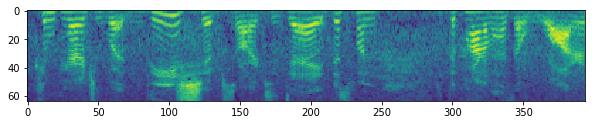

In [6]:
plt.figure(figsize=[10, 3])
plt.imshow(data[0][0])

In [7]:
data_loader = DataLoader(data, batch_size=16, num_workers=16)

In [9]:
for i in tqdm(data_loader):
    pass

In [10]:
net = vggish(include_classifier=True, pretrained=True)

OSError: Unable to open file (unable to open file: name = './models/vggish_audioset_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
net